In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fim import apriori

import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

df = pd.read_csv("../dataset.csv")

<b>Preprocessing</b>

In [2]:
#fill missing values and fix upcase letters
df = df.sort_values(by='familiarity')
df.reset_index(drop=True, inplace=True)
miss_vals = dict(df['web_corpus_freq'].isna())
check_val = []
for x in miss_vals:
    if miss_vals[x] == True:
        check_val.append(x)
        #substitute the missing values with the mean values at the previous and following index
        df.loc[x, 'web_corpus_freq'] = (df['web_corpus_freq'].iloc[x-1]+df['web_corpus_freq'].iloc[x+1])/2
        #fix the uppercase letters
        df.loc[x, 'word'] = df['word'].iloc[x].lower()
df = df.sort_values(by='word') 
df.reset_index(drop=True, inplace=True)

#log transformation of web corpus
df['web_corpus_freq'] = np.log(df['web_corpus_freq'])
df = df.rename({'web_corpus_freq' : 'log_web_corpus_freq'}, axis='columns')

df_bckp = df.copy(deep=True)
raw = df.drop(columns=['word', 'polysemy', 'length'])

#rescaling the features for KNN
X_raw = raw.values
minmax = MinMaxScaler()
df_scaled = pd.DataFrame(minmax.fit_transform(X_raw), columns=raw.columns)
df_scaled.insert(0, 'length', df['length'])
df_scaled['index'] = np.arange(0,4682)

#dropping word
column2drop = ['word']
df.drop(column2drop, axis=1, inplace=True)

In [3]:
df.describe()

,length,arousal,valence,dominance,concreteness,imageability,familiarity,aoa,semsize,gender,polysemy,log_web_corpus_freq
count,4682.000000,4682.000000,4682.000000,4682.000000,4682.000000,4682.000000,4682.000000,4682.000000,4682.000000,4682.000000,4682.000000,4682.000000
mean,6.348355,4.678129,5.086797,5.044939,4.566273,4.723018,5.271335,4.143427,4.136403,4.099933,0.080948,15.624734
std,2.006230,1.097163,1.594344,0.930669,1.433689,1.363110,0.921218,1.252770,1.023293,0.912293,0.272785,1.845378
min,2.000000,2.057000,1.030000,1.941000,1.636000,1.737000,1.647000,1.219000,1.375000,1.000000,0.000000,9.454854
25%,5.000000,3.849000,4.115000,4.529000,3.242000,3.519250,4.706000,3.114000,3.438000,3.606000,0.000000,14.329894
50%,6.000000,4.571000,5.290000,5.123000,4.471000,4.677000,5.438000,4.177000,4.186500,4.121000,0.000000,15.559322
75%,8.000000,5.419000,6.088000,5.600000,5.971000,6.032000,5.969000,5.152000,4.882000,4.656000,0.000000,16.924050
max,16.000000,8.177000,8.647000,8.371000,6.938000,6.941000,6.939000,6.971000,6.912000,6.971000,1.000000,21.427580


<b>Discretization of the continuous variables</b>

In [4]:
#I will create low, medium and high intervals for continous variables by dividing them in 3 bins by quantile (0.33)
bincol_transform = [col for col in df.columns if (col != 'polysemy') and (col != 'length')] #taking only continous variables
print("Intervals for each variable:")

for n, i in enumerate(bincol_transform):
    #n_bins = int(round(math.log(len(df)) / math.log(2),0)) #Sturge's rule just used for comparison purposes
    n_bins = 3
    if n == 8: #the 9th (8+1 by de-indexing) column here is the gender column which I didn't divided by quantile
        df[i+"_bin"] = pd.cut(df[i], n_bins)
    else:
        df[i+"_bin"] = pd.qcut(df[i], n_bins)
    
    to_map = sorted(list(df[i+"_bin"].unique())) #listing the created intervals by their magnitude order to map them
    remappa_labels = {} #empty dictionary to use then to map
    
    for val in to_map:
        intervallo_str = str(val) #transform the interval data type into a string
        print(intervallo_str, end=', ')
        
        if val == to_map[0]:
            remappa_labels[val] = 'low'
        if val == to_map[1]:
            remappa_labels[val] = 'medium'
        if val == to_map[2]:
            remappa_labels[val] = 'high'
        #building the dictionary as such {value_to_change : new_value}
    print(i)    
    df[i+"_bin"] = df[i+"_bin"].map(remappa_labels) #applying the substitutions
    df[i+"_bin"] = df[i+"_bin"].astype(str) + "_" + i #adding the column name next to the value to recognize it later
    
    #print(df[i+"_bin"].unique()
    
df.drop(bincol_transform, axis=1, inplace=True) #dropping old columns with continous variables
df["length"] = df["length"].astype(str) + "_" + "length" #add length next to the value as in the other columns

#Remap polysemy to enhance readability:
pol_dict = {0: 'Not Polysemous', 1: 'Polysemous'}
df['polysemy'] = df['polysemy'].map(pol_dict)

#Remap gender for it to be read:
gen_dict = {'low_gender' : 'Feminine', 'medium_gender' : 'Ambiguous Gender', 'high_gender': 'Male'}
df['gender_bin'] = df['gender_bin'].map(gen_dict)

#Remap web_corpus_freq to enhance readability:
freq_dict = {'low_log_web_corpus_freq' : 'low_frequency', 'medium_log_web_corpus_freq' : 'medium_frequency', 'high_log_web_corpus_freq' : 'high_frequency'}
df['log_web_corpus_freq_bin'] = df['log_web_corpus_freq_bin'].map(freq_dict)
df_pattern = df.copy(deep=True)

Intervals for each variable:
(2.056, 4.088], (4.088, 5.114], (5.114, 8.177], arousal
(1.0290000000000001, 4.734], (4.734, 5.766], (5.766, 8.647], valence
(1.9400000000000002, 4.771], (4.771, 5.424], (5.424, 8.371], dominance
(1.635, 3.606], (3.606, 5.5], (5.5, 6.938], concreteness
(1.7360000000000002, 3.879], (3.879, 5.606], (5.606, 6.941], imageability
(1.6460000000000001, 5.0], (5.0, 5.794], (5.794, 6.939], familiarity
(1.2180000000000002, 3.484], (3.484, 4.824], (4.824, 6.971], aoa
(1.374, 3.71], (3.71, 4.629], (4.629, 6.912], semsize
(0.994, 2.99], (2.99, 4.981], (4.981, 6.971], gender
(9.454, 14.778], (14.778, 16.419], (16.419, 21.428], log_web_corpus_freq


In [5]:
#output dataframe
df

,length,polysemy,arousal_bin,valence_bin,dominance_bin,concreteness_bin,imageability_bin,familiarity_bin,aoa_bin,semsize_bin,gender_bin,log_web_corpus_freq_bin
0,8_length,Not Polysemous,medium_arousal,low_valence,low_dominance,medium_concreteness,medium_imageability,low_familiarity,high_aoa,high_semsize,Male,low_frequency
1,5_length,Not Polysemous,low_arousal,high_valence,low_dominance,high_concreteness,medium_imageability,low_familiarity,high_aoa,high_semsize,Ambiguous Gender,medium_frequency
2,10_length,Not Polysemous,low_arousal,medium_valence,medium_dominance,low_concreteness,low_imageability,medium_familiarity,high_aoa,low_semsize,Ambiguous Gender,low_frequency
3,8_length,Not Polysemous,medium_arousal,low_valence,low_dominance,low_concreteness,low_imageability,low_familiarity,high_aoa,high_semsize,Male,low_frequency
4,10_length,Not Polysemous,low_arousal,low_valence,medium_dominance,low_concreteness,low_imageability,low_familiarity,high_aoa,high_semsize,Ambiguous Gender,low_frequency
...,...,...,...,...,...,...,...,...,...,...,...,...
4677,8_length,Not Polysemous,high_arousal,medium_valence,medium_dominance,high_concreteness,high_imageability,low_familiarity,high_aoa,high_semsize,Male,medium_frequency
4678,4_length,Not Polysemous,low_arousal,low_valence,low_dominance,low_concreteness,medium_imageability,high_familiarity,low_aoa,low_semsize,Ambiguous Gender,high_frequency
4679,4_length,Not Polysemous,high_arousal,high_valence,high_dominance,medium_concreteness,medium_imageability,low_familiarity,high_aoa,low_semsize,Ambiguous Gender,low_frequency
4680,3_length,Not Polysemous,high_arousal,high_valence,high_dominance,high_concreteness,high_imageability,medium_familiarity,low_aoa,high_semsize,Ambiguous Gender,medium_frequency


In [6]:
#to check the correctness and to look at the count for each of the ranges
for i in df.columns:
    counter = str(df[i].value_counts())
    idx = counter.rfind("Name")
    print(counter[:idx])

5_length     912
6_length     910
7_length     777
4_length     732
8_length     492
9_length     316
10_length    221
3_length     157
11_length    108
12_length     39
13_length     11
14_length      4
2_length       2
16_length      1

Not Polysemous    4303
Polysemous         379

low_arousal       1572
medium_arousal    1555
high_arousal      1555

low_valence       1561
high_valence      1561
medium_valence    1560

low_dominance       1568
medium_dominance    1558
high_dominance      1556

low_concreteness       1563
medium_concreteness    1562
high_concreteness      1557

low_imageability       1569
high_imageability      1559
medium_imageability    1554

low_familiarity       1593
medium_familiarity    1545
high_familiarity      1544

medium_aoa    1568
low_aoa       1561
high_aoa      1553

low_semsize       1564
medium_semsize    1562
high_semsize      1556

Ambiguous Gender    3498
Male                 681
Feminine             503

low_frequency       1561
high_frequency   

<b>Extraction of frequent itemsets with the apriori algorithm</b>

In [7]:
X = df.values.tolist() #to run the apriori algorithm
itemsets = apriori(X, target='s', supp=2, zmin=1, report='S') #all frequent itemsets with at least one element and 2% support
print("Number of frequent itemsets with 2% support:", len(itemsets))

Number of frequent itemsets with 2% support: 18157


In [8]:
wanted = 'Polysemous'
num_wanted = 0
ls_wanted = []

for i in itemsets:
    if wanted in i[0]:
        ls_wanted.append(str(i))
        num_wanted += 1
        
showme = 10 #to avoid showing too long list of elements show the first ten elements of the ls_wanted
print("Number of frequent itemsets presenting {} as an element: {}".format(str(wanted), num_wanted), '',
      "{} of the frequent itemest elements containing {} as an element:".format(str(showme), wanted), "\n".join(ls_wanted[:showme]), sep='\n')

Number of frequent itemsets presenting Polysemous as an element: 83

10 of the frequent itemest elements containing Polysemous as an element:
(('Polysemous',), 8.094831268688594)
(('Polysemous', '4_length'), 2.99017513882956)
(('Polysemous', '4_length', 'high_frequency'), 2.007689021785562)
(('Polysemous', '4_length', 'low_aoa'), 2.007689021785562)
(('Polysemous', '4_length', 'Ambiguous Gender'), 2.392140111063648)
(('Polysemous', '5_length'), 2.520290474156343)
(('Polysemous', 'high_familiarity'), 3.73771892353695)
(('Polysemous', 'high_familiarity', 'high_frequency'), 3.032891926527125)
(('Polysemous', 'high_familiarity', 'high_frequency', 'low_aoa'), 2.4562152926099956)
(('Polysemous', 'high_familiarity', 'high_frequency', 'low_aoa', 'Ambiguous Gender'), 2.0290474156343445)


In [9]:
num_elements = 8 #just to look at the itemsets with the highest z_min without rerunning the algorithm 
for x in itemsets:
    if len(x[0]) > num_elements:
        print(x)

(('high_familiarity', 'high_concreteness', 'high_imageability', 'medium_valence', 'low_aoa', 'low_semsize', 'low_arousal', 'Ambiguous Gender', 'Not Polysemous'), 2.0717642033319095)
(('high_aoa', 'low_valence', 'low_frequency', 'low_concreteness', 'low_dominance', 'low_imageability', 'low_familiarity', 'Ambiguous Gender', 'Not Polysemous'), 2.7125160187953865)
(('high_concreteness', 'medium_dominance', 'high_imageability', 'medium_valence', 'low_aoa', 'low_semsize', 'low_arousal', 'Ambiguous Gender', 'Not Polysemous'), 2.285348141819735)


In [10]:
supp = 33.5 #just to look at the itemsets with the highest support without rerunning the algorithm (33.5 because I divided by quantiles of 33%)
for x in itemsets:
    if x[1] > supp:
        print(x)

(('low_imageability',), 33.51131994873985)
(('low_arousal',), 33.5753951302862)
(('low_familiarity',), 34.023921401110634)
(('Ambiguous Gender',), 74.71166168304143)
(('Ambiguous Gender', 'Not Polysemous'), 68.30414352840667)
(('Not Polysemous',), 91.9051687313114)


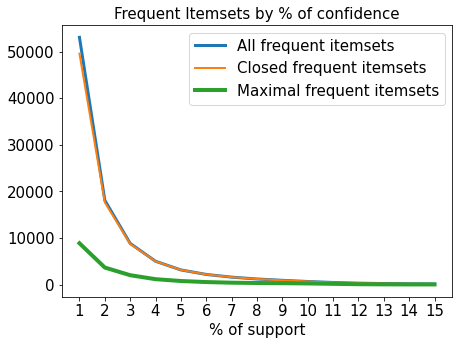

In [11]:
#plotting number of all, closed and maximal frequent itemsets by different levels of support
len_all = []
len_cl_it = []
len_max_it = []
ticks = []

for i in range(1, 15+1):
    cl_itemsets = apriori(X, target='c', supp=i, zmin=2)
    max_itemsets = apriori(X, target='m', supp=i, zmin=2)
    all_itemsets = apriori(X, target='s', supp=i, zmin=2)
    len_all.append( len(all_itemsets))
    len_cl_it.append( len(cl_itemsets) )
    len_max_it.append( len(max_itemsets) )
    ticks.append( i )

plt.figure(figsize=(7,5))
plt.plot(len_all, label='All frequent itemsets', linewidth=3)
plt.plot(len_cl_it, label='Closed frequent itemsets', linewidth=2)
plt.plot(len_max_it, label='Maximal frequent itemsets', linewidth=4)
plt.legend(fontsize=15)
plt.xticks( np.arange(0, 15), ticks, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('% of support', fontsize=15)
plt.title('Frequent Itemsets by % of confidence', fontsize=15)

plt.show()

In [12]:
#now the same but I focus on maximal frequent Itemsets as they rappresent the frequent itemsets without being so many
itemsets = apriori(X, target='m', supp=2, zmin=1, report='S')
print("Number of maximal frequent itemsets with 2% support:", len(itemsets))

for wanted in ['high_frequency', 'Feminine', 'Polysemous']:
    num_wanted = 0
    ls_wanted = []

    for i in itemsets:
        if wanted in i[0]:
            ls_wanted.append(str(i))
            num_wanted += 1

    showme = 10 #to avoid showing too long list of elements show the first ten elements of the ls_wanted
    print("\nNumber of maximal frequent itemsets presenting {} as an element: {}".format(str(wanted), num_wanted),
          "{} of the maximal frequent itemest elements containing {} as an element:".format(str(showme), wanted), "\n".join(ls_wanted[:showme]), sep='\n')

Number of maximal frequent itemsets with 2% support: 3693

Number of maximal frequent itemsets presenting high_frequency as an element: 518
10 of the maximal frequent itemest elements containing high_frequency as an element:
(('Polysemous', '4_length', 'high_frequency'), 2.007689021785562)
(('Polysemous', 'high_familiarity', 'high_frequency', 'low_aoa', 'Ambiguous Gender'), 2.0290474156343445)
(('Polysemous', 'medium_dominance', 'high_frequency'), 2.135839384878257)
(('Polysemous', 'medium_valence', 'high_frequency', 'Ambiguous Gender'), 2.2212729602733874)
(('Polysemous', 'high_frequency', 'medium_concreteness'), 2.1571977787270398)
(('8_length', 'high_frequency', 'Not Polysemous'), 2.498932080307561)
(('Feminine', 'high_familiarity', 'high_valence', 'high_frequency'), 2.050405809483127)
(('Feminine', 'high_arousal', 'high_frequency'), 2.0717642033319095)
(('Feminine', 'high_valence', 'high_frequency', 'Not Polysemous'), 2.2212729602733874)
(('Male', 'high_semsize', 'high_frequency', 

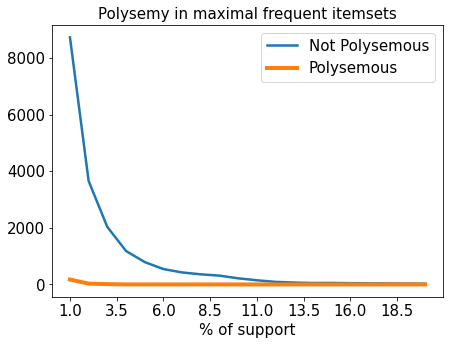

In [13]:
filter_1 = []
filter_2 = []
filter_3 = []
filter_4 = []

for i in range(1, 20+1):
    max_itemsets = apriori(X, target='m', supp=i, zmin=3)
    
    filter_1.append( len([item for item in max_itemsets if wanted not in item[0]]) )
    filter_2.append( len([item for item in max_itemsets if wanted in item[0]])  )

if ',' in wanted:
    comma = wanted.find(',')
    wanted_first_num = round(float(wanted[1:comma]), 3)
    wanted_new = '(' + str(wanted_first_num) + wanted[comma:]
else:
    wanted_new = wanted

plt.figure(figsize=(7,5))
plt.plot(filter_1, label='Not ' + wanted_new, linewidth=2.5)
plt.plot(filter_2, label='' + wanted_new, linewidth=4)
plt.legend(fontsize=15)
plt.xticks(np.arange(0,20,2.5), np.arange(1,21,2.5), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('% of support', fontsize=15)
plt.title('Polysemy in maximal frequent itemsets', fontsize=15)

plt.show()

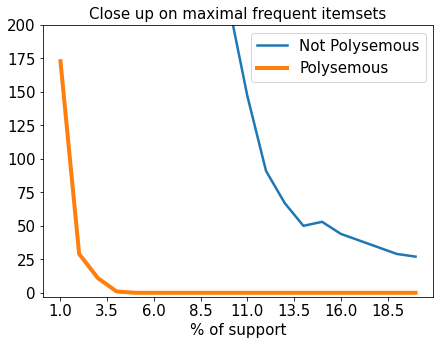

In [14]:
filter_1 = []
filter_2 = []
filter_3 = []
filter_4 = []

for i in range(1, 20+1):
    max_itemsets = apriori(X, target='m', supp=i, zmin=3)
    
    filter_1.append( len([item for item in max_itemsets if wanted not in item[0]]) )
    filter_2.append( len([item for item in max_itemsets if wanted in item[0]])  )

if ',' in wanted:
    comma = wanted.find(',')
    wanted_first_num = round(float(wanted[1:comma]), 3)
    wanted_new = '(' + str(wanted_first_num) + wanted[comma:]
else:
    wanted_new = wanted

plt.figure(figsize=(7,5))
plt.plot(filter_1, label='Not ' + wanted_new, linewidth=2.5)
plt.plot(filter_2, label='' + wanted_new, linewidth=4)
plt.legend(fontsize=15)
plt.xticks(np.arange(0,20,2.5), np.arange(1,21,2.5), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('% of support', fontsize=15)
plt.ylim(-3,200)
plt.title("Close up on maximal frequent itemsets", fontsize=15)


plt.show()

<b>Exploring association rules, disclaimer for the 4 following cells:</b> very slow to compute, do not run if in a hurry

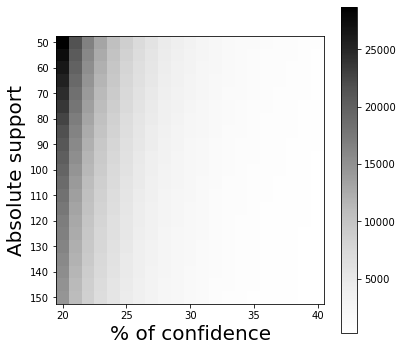

In [15]:
#level of confidence from 20 to 40
#level of supports from 50 to 155
#8 minimu number of elements

confidence_from = 20
confidence_to = 40
len_r = []
for i in range(confidence_from, confidence_to+1): #confidence
    len_r_wrt_i = []
    for j in np.arange(-50,-155, -5): #support
        rules = apriori(X, target='r', supp=j, zmin=8, conf=i, report='aScl')
        len_r_wrt_i.append(len(rules))
        
    len_r.append(len_r_wrt_i)
    
plt.figure(figsize=(6,6))
plt.imshow( len_r, cmap='Greys', alpha=1.0)
plt.xlabel('% of confidence', fontsize=20)
plt.ylabel('Absolute support', fontsize=20)
plt.yticks(np.arange(0.00, 20.0+2, 2), np.arange(50,150+10, 10))
plt.xticks(np.arange(0,21, 5), np.arange(confidence_from,confidence_to+1, 5))
plt.colorbar()

plt.show()

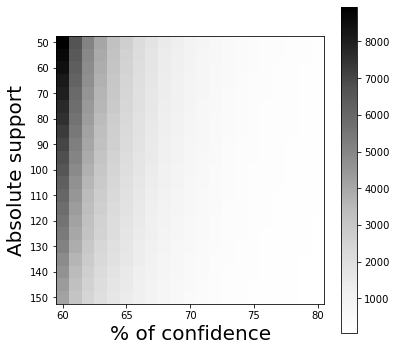

In [16]:
#level of confidence from 60 to 80
#level of supports from 50 to 155
#8 minimu number of elements

confidence_from = 60
confidence_to = 80
len_r = []
for i in range(confidence_from, confidence_to+1): #confidence
    len_r_wrt_i = []
    for j in np.arange(-50,-155, -5): #support
        rules = apriori(X, target='r', supp=j, zmin=8, conf=i, report='aScl')
        len_r_wrt_i.append(len(rules))
        
    len_r.append(len_r_wrt_i)
    
plt.figure(figsize=(6,6))
plt.imshow( len_r, cmap='Greys', alpha=1.0)
plt.xlabel('% of confidence', fontsize=20)
plt.ylabel('Absolute support', fontsize=20)
plt.yticks(np.arange(0.00, 20.0+2, 2), np.arange(50,150+10, 10))
plt.xticks(np.arange(0,21, 5), np.arange(confidence_from,confidence_to+1, 5))
plt.colorbar()

plt.show()

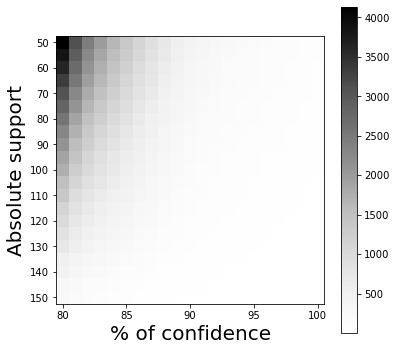

In [17]:
#level of confidence from 80 to 100
#level of supports from 50 to 155
#8 minimu number of elements

confidence_from = 80
confidence_to = 100
len_r = []
for i in range(confidence_from, confidence_to+1): #confidence
    len_r_wrt_i = []
    for j in np.arange(-50,-155, -5): #support
        rules = apriori(X, target='r', supp=j, zmin=8, conf=i, report='aScl')
        len_r_wrt_i.append(len(rules))
        
    len_r.append(len_r_wrt_i)

plt.figure(figsize=(6,6))
plt.imshow( len_r, cmap='Greys', alpha=1.0)
plt.xlabel('% of confidence', fontsize=20)
plt.ylabel('Absolute support', fontsize=20)
plt.yticks(np.arange(0.00, 20.0+2, 2), np.arange(50,150+10, 10))
plt.xticks(np.arange(0,21, 5), np.arange(confidence_from,confidence_to+1, 5))
plt.colorbar()

plt.show()

In [18]:
length = []
poly_r = []
feminine_r = []
length_r = []
frequency_r = []
for x in range(1,100):
    poly_r_count = 0
    feminine_r_count = 0
    length_r_count = 0
    frequency_r_count = 0
    rules = apriori(X, target='r', supp=2, zmin=8, conf=x, report='aScl')
    for r in rules:
        if r[0] == 'Polysemous':
            poly_r_count += 1
        if r[0] == 'Feminine':
            feminine_r_count +=1
        if r[0] == '4_length':
            length_r_count +=1
        if r[0] == 'high_frequency':
            frequency_r_count +=1
    length.append(len(rules))
    poly_r.append(poly_r_count)
    feminine_r.append(feminine_r_count)
    length_r.append(length_r_count)
    frequency_r.append(frequency_r_count)

Text(0.5, 1.0, 'Number of Association (2% support)')

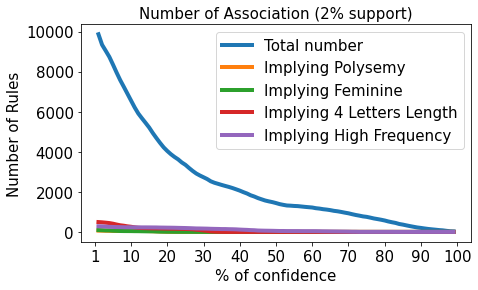

In [19]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, 100), length, label="Total number", linewidth=4)
plt.plot(np.arange(1, 100), poly_r, label="Implying Polysemy", linewidth=4)
plt.plot(np.arange(1, 100), feminine_r, label="Implying Feminine", linewidth=4)
plt.plot(np.arange(1, 100), length_r, label="Implying 4 Letters Length", linewidth=4)
plt.plot(np.arange(1, 100), frequency_r, label="Implying High Frequency", linewidth=4)
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
confidence_xticks = np.arange(0,110,10)
confidence_xticks[0] = 1
plt.xticks(np.arange(0,110,10), confidence_xticks, fontsize=15)
plt.xlabel('% of confidence', fontsize=15)
plt.ylabel('Number of Rules', fontsize=15)
plt.title('Number of Association (2% support)', fontsize=15)

Text(0.5, 1.0, 'Number of Association (2% support)')

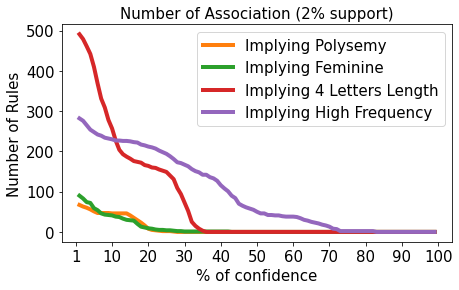

In [20]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, 100), poly_r, linewidth=1)
plt.plot(np.arange(1, 100), poly_r, label="Implying Polysemy", linewidth=4)
plt.plot(np.arange(1, 100), feminine_r, label="Implying Feminine", linewidth=4)
plt.plot(np.arange(1, 100), length_r, label="Implying 4 Letters Length", linewidth=4)
plt.plot(np.arange(1, 100), frequency_r, label="Implying High Frequency", linewidth=4)
plt.legend(fontsize=15)
plt.yticks(fontsize=15)
confidence_xticks = np.arange(0,110,10)
confidence_xticks[0] = 1
plt.xticks(np.arange(0,110,10), confidence_xticks, fontsize=15)
plt.xlabel('% of confidence', fontsize=15)
plt.ylabel('Number of Rules', fontsize=15)
plt.title('Number of Association (2% support)', fontsize=15)

<b>Extraction of association rules with the apriori algorithm</b>

In [21]:
supp = 2
zmin = 1
conf = 55
rules = apriori(X, target='r', supp=supp, zmin=zmin, conf=conf, report='aScl')
print("Number of association rules with {}% support, minimum {} elements and {}% of confidence: {}".format(supp, zmin, conf, len(rules)), '\n')

rules_storage = [] #to append the rules corresponding to the requisites
wanted = 'Feminine'
print("Association rules with the same thresholds with {} as an element:".format(wanted))
lift = 4.35
num_rules = 0
for r in rules:
    if r[0] == wanted and r[5] > lift:
        rules_storage.append(r)
        num_rules +=1
        print("{} imply ('{}')\nwith a support of {}, a confidence of {} and a lift of {}".format(r[1], r[0], r[2], r[4], r[5]))

Number of association rules with 2% support, minimum 1 elements and 55% of confidence: 65321 

Association rules with the same thresholds with Feminine as an element:
('high_arousal', 'high_valence', 'low_semsize', 'Not Polysemous') imply ('Feminine')
with a support of 71, a confidence of 0.6068376068376068 and a lift of 5.648536133625597
('high_arousal', 'high_valence', 'low_semsize') imply ('Feminine')
with a support of 74, a confidence of 0.6016260162601627 and a lift of 5.600025861093601


In [22]:
supp = 2
zmin = 1
conf = 1
rules = apriori(X, target='r', supp=supp, zmin=zmin, conf=conf, report='aScl')
print("Number of association rules with {}% support, minimum {} elements and {}% of confidence: {}".format(supp, zmin, conf, len(rules)), '\n')

wanted = 'Polysemous'
print("Association rules with the same thresholds with {} as an element:".format(wanted))
lift = 4.35
num_rules = 0
for r in rules:
    if (r[0] == wanted and r[5] > lift) or (r[0] == wanted and len(r[1]) > 6 and r[5] > lift-1): #extracting also a rule with more elements than 6 with a slightly lower lift
        rules_storage.append(r)
        num_rules +=1
        print("{} imply ('{}')\nwith a support of {}, a confidence of {} and a lift of {}".format(r[1], r[0], r[2], r[4], r[5]))

Number of association rules with 2% support, minimum 1 elements and 1% of confidence: 490318 

Association rules with the same thresholds with Polysemous as an element:
('4_length', 'medium_dominance', 'high_frequency', 'Ambiguous Gender') imply ('Polysemous')
with a support of 39, a confidence of 0.36792452830188677 and a lift of 4.545178473639668
('4_length', 'medium_dominance', 'high_frequency') imply ('Polysemous')
with a support of 46, a confidence of 0.35658914728682173 and a lift of 4.405146141416621
('high_familiarity', 'high_concreteness', 'high_imageability', 'high_frequency', 'low_aoa', 'low_semsize', 'Ambiguous Gender') imply ('Polysemous')
with a support of 29, a confidence of 0.27358490566037735 and a lift of 3.3797480957833423


In [23]:
supp = 2
zmin = 1
conf = 85
rules = apriori(X, target='r', supp=supp, zmin=zmin, conf=conf, report='aScl')
print("Number of association rules with {}% support, minimum {} elements and {}% of confidence: {}".format(supp, zmin, conf, len(rules)), '\n')

wanted = 'high_frequency'
print("Association rules with the same thresholds with {} as an element:".format(wanted))
lift = 0
num_rules = 0
for r in rules:
    if r[0] == wanted and r[5] > lift:
        rules_storage.append(r)
        num_rules +=1
        print("{} imply ('{}')\nwith a support of {}, a confidence of {} and a lift of {}".format(r[1], r[0], r[2], r[4], r[5]))

Number of association rules with 2% support, minimum 1 elements and 85% of confidence: 15477 

Association rules with the same thresholds with high_frequency as an element:
('high_familiarity', 'high_semsize', 'high_valence', 'low_aoa', 'Ambiguous Gender') imply ('high_frequency')
with a support of 118, a confidence of 0.855072463768116 and a lift of 2.5646696190661875
('high_familiarity', 'medium_valence', 'medium_concreteness', 'Ambiguous Gender') imply ('high_frequency')
with a support of 101, a confidence of 0.8559322033898306 and a lift of 2.567248287169242
('high_familiarity', 'high_valence', 'medium_concreteness', 'Ambiguous Gender') imply ('high_frequency')
with a support of 124, a confidence of 0.8551724137931035 and a lift of 2.5649694051116656


<b>Applying the association rules and comparing it to knn</b> (Done as an exercise)

In [24]:
#encoding labels into numerical values
df = pd.DataFrame()
columns = [i for i in df_bckp.columns if i not in ['word']]
for i in columns:
    if i == 'length':
        df['length'] = df_bckp['length']
    elif i == 'polysemy':
        df['polysemy'] = df_bckp['polysemy']
    elif i == 'gender':
        dictmap = {'Feminine' : 0, 'Ambiguous Gender' : 1, 'Male' : 2}
        df['gender_bin'] = df_pattern['gender_bin'].map(dictmap)
    elif i == 'log_web_corpus_freq':
        dictmap = {'low_frequency' : 0, 'medium_frequency' : 1, 'high_frequency' : 2}
        df['log_web_corpus_freq_bin'] = df_pattern['log_web_corpus_freq_bin'].map(dictmap)
    else:
        dictmap = {'low_'+i : 0, 'medium_'+i: 1, 'high_'+i: 2}
        df[i+'_bin'] = df_pattern[i+'_bin'].map(dictmap)
df

,length,arousal_bin,valence_bin,dominance_bin,concreteness_bin,imageability_bin,familiarity_bin,aoa_bin,semsize_bin,gender_bin,polysemy,log_web_corpus_freq_bin
0,8,1,0,0,1,1,0,2,2,2,0,0
1,5,0,2,0,2,1,0,2,2,1,0,1
2,10,0,1,1,0,0,1,2,0,1,0,0
3,8,1,0,0,0,0,0,2,2,2,0,0
4,10,0,0,1,0,0,0,2,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4677,8,2,1,1,2,2,0,2,2,2,0,1
4678,4,0,0,0,0,1,2,0,0,1,0,2
4679,4,2,2,2,1,1,0,2,0,1,0,0
4680,3,2,2,2,2,2,1,0,2,1,0,1


In [25]:
for n, el in enumerate(rules_storage): #I select which rule to test
    print("Rule ", n)
    print(el[1], "-> ('{}')\n".format(el[0]), "support of {}, confidence of {} and lift of {}".format(el[2], el[4], el[5]))

Rule  0
('high_arousal', 'high_valence', 'low_semsize', 'Not Polysemous') -> ('Feminine')
 support of 71, confidence of 0.6068376068376068 and lift of 5.648536133625597
Rule  1
('high_arousal', 'high_valence', 'low_semsize') -> ('Feminine')
 support of 74, confidence of 0.6016260162601627 and lift of 5.600025861093601
Rule  2
('4_length', 'medium_dominance', 'high_frequency', 'Ambiguous Gender') -> ('Polysemous')
 support of 39, confidence of 0.36792452830188677 and lift of 4.545178473639668
Rule  3
('4_length', 'medium_dominance', 'high_frequency') -> ('Polysemous')
 support of 46, confidence of 0.35658914728682173 and lift of 4.405146141416621
Rule  4
('high_familiarity', 'high_concreteness', 'high_imageability', 'high_frequency', 'low_aoa', 'low_semsize', 'Ambiguous Gender') -> ('Polysemous')
 support of 29, confidence of 0.27358490566037735 and lift of 3.3797480957833423
Rule  5
('high_familiarity', 'high_semsize', 'high_valence', 'low_aoa', 'Ambiguous Gender') -> ('high_frequency'

In [26]:
to_apply_rules = []
for n in [2, 7]: #I decided to apply rules 2 and 7
    el = rules_storage[n] #I'll print them to copy the values for building a confusion matrix
    print("Rule ", n)
    print(el[1], "-> ('{}')\n".format(el[0]), "support of {}, confidence of {} and lift of {}".format(el[2], el[4], el[5]))

Rule  2
('4_length', 'medium_dominance', 'high_frequency', 'Ambiguous Gender') -> ('Polysemous')
 support of 39, confidence of 0.36792452830188677 and lift of 4.545178473639668
Rule  7
('high_familiarity', 'high_valence', 'medium_concreteness', 'Ambiguous Gender') -> ('high_frequency')
 support of 124, confidence of 0.8551724137931035 and lift of 2.5649694051116656


In [27]:
for n, el in enumerate(df.columns):
    print(n, el, end=' - ') #to remember the indexes in the array

0 length - 1 arousal_bin - 2 valence_bin - 3 dominance_bin - 4 concreteness_bin - 5 imageability_bin - 6 familiarity_bin - 7 aoa_bin - 8 semsize_bin - 9 gender_bin - 10 polysemy - 11 log_web_corpus_freq_bin - 

Now I will test the rules splitting the dataset in training and test set and then applying the rule, training knn on the training set and finally testing on the test set an comparing performances.</br></br>
<b>Polysemy implying rule</b>

In [28]:
attrib = [col for col in df_scaled.columns if col != 'polysemy']
X = df_scaled[attrib].values
y = df['polysemy']
df = df.drop(columns=['polysemy'])

knnX_train, knnX_test, knny_train, knny_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)
X_train, X_test, y_train, y_test = df.loc[knnX_train[:,-1]].values, df.loc[knnX_test[:,-1]].values, knny_train[:], knny_test[:]
knnX_test = np.delete(knnX_test, -1, 1) #I get rid of the indeces for the test set

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1291
           1       0.30      0.09      0.14       114

    accuracy                           0.91      1405
   macro avg       0.61      0.53      0.54      1405
weighted avg       0.87      0.91      0.89      1405



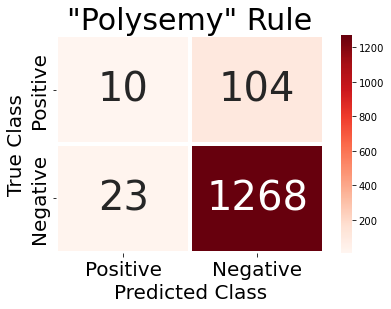

In [29]:
#Rule 2
prediction_poly = []
for x in range(0,len(X_test)):
    if X_test[:,0][x] == 4 and X_test[:,3][x] == 1 and X_test[:,10][x] == 2 and X_test[:,9][x] == 1:
        prediction_poly.append(1)
    else:
        prediction_poly.append(0)

trues_poly = y_test[:]

cf_poly = confusion_matrix(trues_poly, prediction_poly, labels=[1,0])

#plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6,4)) 
sns.heatmap(cf_poly, annot=True, annot_kws={"size": 40}, linewidths=4, cmap="Reds", fmt='g')

ax.set_xticklabels(['Positive','Negative'], fontsize=20)
ax.set_xlabel('Predicted Class', fontsize=20)
ax.set_yticklabels(['Positive','Negative'], verticalalignment='center', fontsize=20)
ax.set_ylabel('True Class', fontsize=20)

plt.title('"Polysemy" Rule', fontsize=30)

print(classification_report(trues_poly, prediction_poly))

In [30]:
base_to_undersample = pd.DataFrame(knnX_train, columns = ['length', 1,2,3,4,5,6,7,8,9,10, 'index'])
base_to_undersample['polysemy'] = knny_train.to_list()

to_undersample = base_to_undersample[base_to_undersample['polysemy'] == 0]
minority_class = base_to_undersample[base_to_undersample['polysemy'] == 1]
to_undersample.describe()

#as it can be seen I preferred to sample stratifying according to length (which is easily one of the most important features)
data_0_1 = to_undersample.query("length >= 0 & length < 5").sample(n=67,random_state=42)
data_0_2 = to_undersample.query("length >= 5 & length < 6").sample(n=66,random_state=42)
data_0_3 = to_undersample.query("length >= 6 & length < 8").sample(n=66,random_state=42)
data_0_4 = to_undersample.query("length >= 8 & length < 16").sample(n=66,random_state=42)

#I concatenate everything
new_data = data_0_1.append(data_0_2).append(data_0_3).append(data_0_4)
#I append polysemy back
new_train = minority_class.append(new_data, ignore_index=True)
#I shuffle the dataframe (otherwise I would have to do it later to avoid performing biased gridsearches)
new_train = new_train.sample(frac=1, random_state=42).reset_index(drop=True)

#I re-defain the training and test set
attributes = [col for col in df_scaled.columns if col not in ['polysemy', 'index']]
knny_train = new_train['polysemy']
knnX_train = new_train.drop(columns=['index', 'polysemy']).values

In [31]:
gs = {'n_neighbors' : np.arange(1,25)}
knn_param_search = GridSearchCV(KNeighborsClassifier(), gs, cv = ms.KFold(n_splits=5, shuffle=True, ), scoring='f1')
knn_param_search.fit(knnX_train, knny_train)
res = knn_param_search.cv_results_ 

def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(res)

print(knn_param_search.best_params_)

k = knn_param_search.best_params_['n_neighbors']
print("I will use k = {}".format(k))

Model with rank: 1
Mean validation score: 0.721 (std: 0.041)
Parameters: {'n_neighbors': 17}

Model with rank: 2
Mean validation score: 0.720 (std: 0.048)
Parameters: {'n_neighbors': 23}

Model with rank: 3
Mean validation score: 0.719 (std: 0.038)
Parameters: {'n_neighbors': 13}

Model with rank: 4
Mean validation score: 0.717 (std: 0.038)
Parameters: {'n_neighbors': 15}

Model with rank: 5
Mean validation score: 0.714 (std: 0.044)
Parameters: {'n_neighbors': 18}

{'n_neighbors': 17}
I will use k = 17


In [32]:
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(knnX_train, knny_train)

KNeighborsClassifier(n_neighbors=17)

In [33]:
knny_pred_test = clf.predict(knnX_test)
cf_knn = confusion_matrix(knny_test, knny_pred_test, labels=[1,0])
print( classification_report(knny_test, knny_pred_test) )

              precision    recall  f1-score   support

           0       0.98      0.53      0.69      1291
           1       0.14      0.87      0.24       114

    accuracy                           0.56      1405
   macro avg       0.56      0.70      0.47      1405
weighted avg       0.91      0.56      0.65      1405



Text(0.5, 1.0, 'KNN Threshold 0.50')

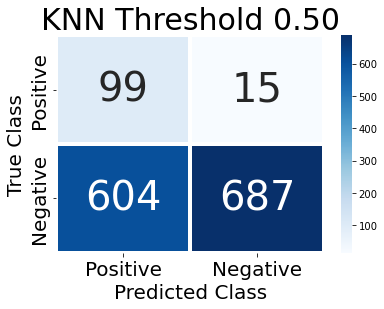

In [34]:
fig, ax = plt.subplots(figsize=(6,4)) 
sns.heatmap(cf_knn, annot=True, annot_kws={"size": 40}, linewidths=4, cmap="Blues", fmt='g')

ax.set_xticklabels(['Positive','Negative'], fontsize=20)
ax.set_xlabel('Predicted Class', fontsize=20)
ax.set_yticklabels(['Positive','Negative'], verticalalignment='center', fontsize=20)
ax.set_ylabel('True Class', fontsize=20)

plt.title("KNN Threshold 0.50", fontsize=30)

In [35]:
knny_score = clf.predict_proba(knnX_test)
fpr, tpr, th = roc_curve(knny_test, knny_score[:,1])
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(knny_test, knny_score[:,1])
proc_auc = auc(recall, precision)

print('ROC AUC:', roc_auc)
print('PR Curve AUC:', proc_auc)

ROC AUC: 0.7408679522198215
PR Curve AUC: 0.15188673636730127


The following is the same as in classification, I just copied my own code

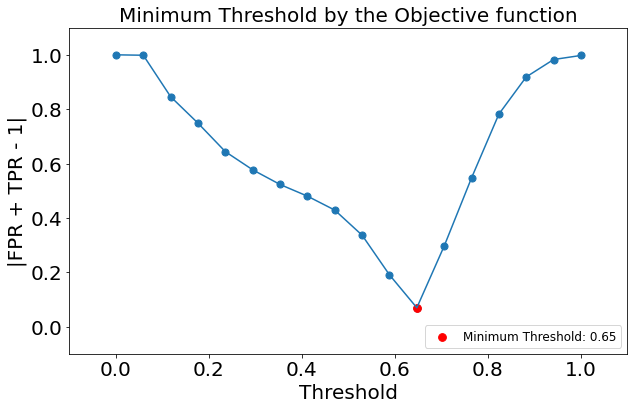

In [36]:
plt.figure(figsize=(10,6))
plt.scatter(th[1:],np.abs(fpr+tpr-1)[1:], s=50)
plt.plot(th[1:],np.abs(fpr+tpr-1)[1:])
itemindex = np.where(th==th[np.argmin(np.abs(fpr+tpr-1))])
plt.xlabel("Threshold", fontsize=20)
plt.ylabel("|FPR + TPR - 1|", fontsize=20)
plt.scatter(th[np.argmin(np.abs(fpr+tpr-1))],np.abs(fpr+tpr-1)[itemindex], c='r', s=60, label='Minimum Threshold: {:.2f}'.format(th[np.argmin(np.abs(fpr+tpr-1))]))
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower right',fontsize=12)
plt.title('Minimum Threshold by the Objective function', fontsize=20)
plt.show()

minimo_threshold = th[np.argmin(np.abs(fpr+tpr-1))]

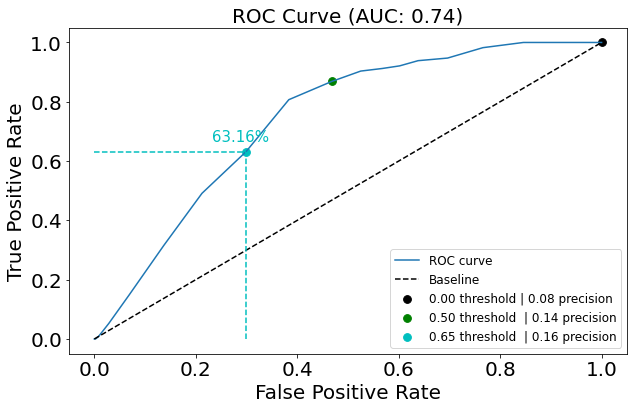

In [37]:
#I wrote a function to plot the roc curve with some info on the graph
def threshold_roc_plotter(X_test, y_test, th_range_array=np.arange(0.001,2.00,0.50), clf=None):
    y_score1 = clf.predict_proba(X_test)[:,1]
    
    plt.figure(figsize=(10,6))
    fp_rate, tp_rate, threshold = roc_curve(y_test, y_score1)
    roc_auc = auc(fp_rate, tp_rate)
    
    plt.plot(fp_rate, tp_rate, label='ROC curve')
    plt.plot([0,1], [0,1], 'k--', label='Baseline')
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    colori = {0:'b', 1:'g', 2:'c', 3:'r', 4:'m', 5:'k', 6:'y'}
    
    for i, thr in enumerate(th_range_array):
        if thr==1:
            y_pred_test = [1 if v > thr else 0 for v in y_score1]
        else:
            y_pred_test = [1 if v >= thr else 0 for v in y_score1]
        cf = confusion_matrix(y_test, y_pred_test, labels=[1,0])
        
        TP = cf[0][0]
        FN = cf[0][1]
        FP = cf[1][0]
        TN = cf[1][1]
        
        veri = TP / (TP + FN)
        falsi = FP / (FP + TN)

        if thr >= 1:
            if i <= 6:
                plt.plot([falsi,falsi], [0,veri], str(colori[i])+'--')
                plt.plot([0,falsi], [veri,veri], str(colori[i])+'--')
                plt.scatter(falsi, veri, marker='o', s=60, color='b', label='1.00 threshold')
            else:
                plt.plot([falsi,falsi], [0,veri], str(colori[i-6*(i//6)])+'--')
                plt.plot([0,falsi], [veri,veri], str(colori[i-6*(i//6)])+'--')
                plt.scatter(falsi, veri, marker='o', s=60, color='b', label='1.00 threshold')
            break
        
        if thr == 0.501:
            precision = TP / (TP + FP)
            string_precision = ' | ' + str(round(precision, 2)) + ' precision'
            plt.scatter(falsi, veri, marker='o', s=60, color=str(colori[i]), label='{:.2f} threshold {}'.format(thr, string_precision))

        elif thr > 0 and thr != 0.501:
            precision = TP / (TP + FP)
            string_precision = ' | ' + str(round(precision, 2)) + ' precision'
            if i <= 6:
                plt.plot([falsi,falsi], [0,veri], str(colori[i])+'--')
                plt.plot([0,falsi], [veri,veri], str(colori[i])+'--')
                plt.scatter(falsi, veri, marker='o', s=60, color=str(colori[i]), label='{:.2f} threshold {}'.format(thr, string_precision))
                plt.text(falsi-0.01, veri+0.05, str(round(veri*100,2))+'%', horizontalalignment='center',verticalalignment='center', c=colori[i], fontsize=15)
            else:
                plt.plot([falsi,falsi], [0,veri], str(colori[i-6*(i//6)])+'--')
                plt.plot([0,falsi], [veri,veri], str(colori[i-6*(i//6)])+'--')
                plt.scatter(falsi, veri, marker='o', s=60, color=str(colori[i-6*(i//6)]), label='{:.2f} threshold {}'.format(thr, string_precision))            
        else: # threshold equal to 0
            precision = TP / (TP + FP)
            string_precision = ' | ' + str(round(precision, 2)) + ' precision'
            plt.scatter(falsi, veri, marker='o', s=60, color='k', label='0.00 threshold'+string_precision)            
                
    plt.legend(loc='best',fontsize=12)
    plt.title('ROC Curve (AUC: '+str(round(roc_auc,2))+')', fontsize=20)

th_range_array = np.array([0, 0.501, minimo_threshold])
threshold_roc_plotter(knnX_test, knny_test, th_range_array, clf)

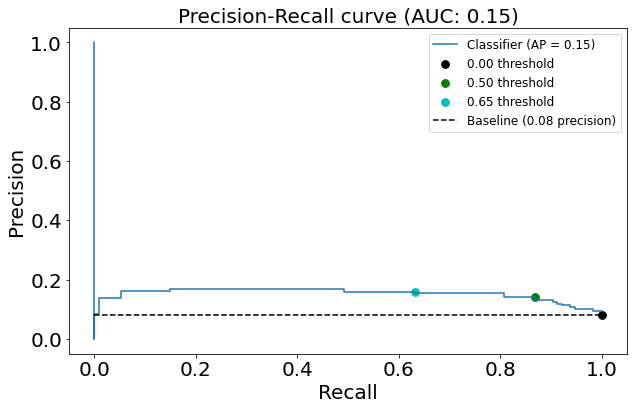

In [38]:
fig = plt.figure(figsize=(10,6))

ax = plt.axes()
display = PrecisionRecallDisplay.from_predictions(knny_test, knny_score[:,1], ax = ax)
display.ax_.set_title("Precision-Recall curve (AUC: {:.2f})".format(proc_auc), fontsize=20)

plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

colori = {0:'k', 1:'g', 2:'c', 3:'r', 4:'m', 5:'y', 6:'b'}

for i, thr in enumerate(th_range_array):
    if thr==1:
        knny_pred_test = [1 if v > thr else 0 for v in clf.predict_proba(knnX_test)[:,1]]
    else:
        knny_pred_test = [1 if v >= thr else 0 for v in clf.predict_proba(knnX_test)[:,1]]
        
    cf = confusion_matrix(knny_test, knny_pred_test, labels=[1,0])
    TP = cf[0][0]
    FN = cf[0][1]
    FP = cf[1][0]
    TN = cf[1][1]

    veri = TP / (TP + FN)
    falsi = FP / (FP + TN)
        
    if thr != 1:
        precisione = TP / (TP + FP)
        plt.scatter(veri, precisione, c=str(colori[i]), s=60, label='{:.2f} threshold'.format(thr))
        
    if thr == 0:
        nervi = precisione

plt.plot([0,1], [nervi,nervi], '--k', label='Baseline ({:0.2f} precision)'.format(nervi))
plt.legend(fontsize=12)

<b>High frequency implying rule</b>

In [39]:
attrib = [col for col in df_scaled.columns if col != 'log_web_corpus_freq_bin']
df['polysemy'] = y
X = df_scaled[attrib].values

y = [] #I need to create a new variable for this

for x in df['log_web_corpus_freq_bin']:
    if x == 2:
        y.append(1)
    else:
        y.append(0)

knnX_train, knnX_test, knny_train, knny_test = train_test_split(X, pd.Series(y), test_size=0.3, stratify=y, random_state=10)
X_train, X_test, y_train, y_test = df.loc[knnX_train[:,-1]].values, df.loc[knnX_test[:,-1]].values, knny_train[:], knny_test[:]
knnX_train = np.delete(knnX_train, -1, 1) 
knnX_test = np.delete(knnX_test, -1, 1) 

              precision    recall  f1-score   support

           0       0.69      0.99      0.81       937
           1       0.88      0.10      0.19       468

    accuracy                           0.70      1405
   macro avg       0.78      0.55      0.50      1405
weighted avg       0.75      0.70      0.60      1405



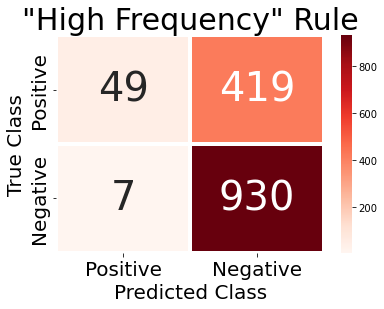

In [40]:
#Rule 7
prediction_freq = []
for x in range(0,len(X_test)):
    if X_test[:,6][x] == 2 and X_test[:,2][x] == 2 and X_test[:,4][x] == 1 and X_test[:,9][x] == 1:
        prediction_freq.append(1)
    else:
        prediction_freq.append(0)

trues_freq = y_test
        
cf_freq = confusion_matrix(trues_freq, prediction_freq, labels=[1,0])
fig, ax = plt.subplots(figsize=(6,4)) 
sns.heatmap(cf_freq, annot=True, annot_kws={"size": 40}, linewidths=4, cmap="Reds", fmt='g')

ax.set_xticklabels(['Positive','Negative'], fontsize=20)
ax.set_xlabel('Predicted Class', fontsize=20)
ax.set_yticklabels(['Positive','Negative'], verticalalignment='center', fontsize=20)
ax.set_ylabel('True Class', fontsize=20)

plt.title('"High Frequency" Rule', fontsize=30)

print(classification_report(trues_freq, prediction_freq))

In [41]:
gs = {'n_neighbors' : np.arange(1,25)}
knn_param_search = GridSearchCV(KNeighborsClassifier(), gs, scoring='f1')
knn_param_search.fit(knnX_train, knny_train)
res = knn_param_search.cv_results_ 

def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(res)

print(knn_param_search.best_params_)

k = knn_param_search.best_params_['n_neighbors']
print("I will use k = {}".format(k))

Model with rank: 1
Mean validation score: 0.790 (std: 0.017)
Parameters: {'n_neighbors': 13}

Model with rank: 2
Mean validation score: 0.786 (std: 0.019)
Parameters: {'n_neighbors': 5}

Model with rank: 3
Mean validation score: 0.785 (std: 0.016)
Parameters: {'n_neighbors': 17}

Model with rank: 4
Mean validation score: 0.784 (std: 0.011)
Parameters: {'n_neighbors': 19}

Model with rank: 5
Mean validation score: 0.780 (std: 0.022)
Parameters: {'n_neighbors': 15}

{'n_neighbors': 13}
I will use k = 13


In [42]:
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(knnX_train, knny_train)

KNeighborsClassifier(n_neighbors=13)

In [43]:
knny_pred_test = clf.predict(knnX_test)
cf_knn = confusion_matrix(knny_test, knny_pred_test, labels=[1,0])
print( classification_report(knny_test, knny_pred_test) )

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       937
           1       0.86      0.76      0.81       468

    accuracy                           0.88      1405
   macro avg       0.88      0.85      0.86      1405
weighted avg       0.88      0.88      0.88      1405



Text(0.5, 1.0, 'KNN Threshold 0.50')

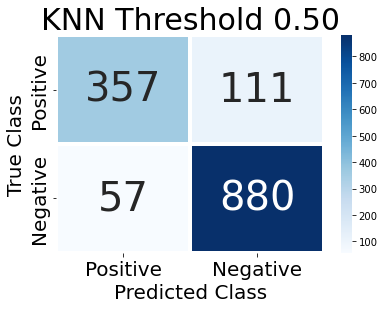

In [44]:
fig, ax = plt.subplots(figsize=(6,4)) 
sns.heatmap(cf_knn, annot=True, annot_kws={"size": 40}, linewidths=4, cmap="Blues", fmt='g')

ax.set_xticklabels(['Positive','Negative'], fontsize=20)
ax.set_xlabel('Predicted Class', fontsize=20)
ax.set_yticklabels(['Positive','Negative'], verticalalignment='center', fontsize=20)
ax.set_ylabel('True Class', fontsize=20)

plt.title("KNN Threshold 0.50", fontsize=30)

In [45]:
knny_score = clf.predict_proba(knnX_test)
fpr, tpr, th = roc_curve(knny_test, knny_score[:,1])
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(knny_test, knny_score[:,1])
proc_auc = auc(recall, precision)

print('ROC AUC:', roc_auc)
print('PR Curve AUC:', proc_auc)

ROC AUC: 0.9415346304353776
PR Curve AUC: 0.9012621202192236


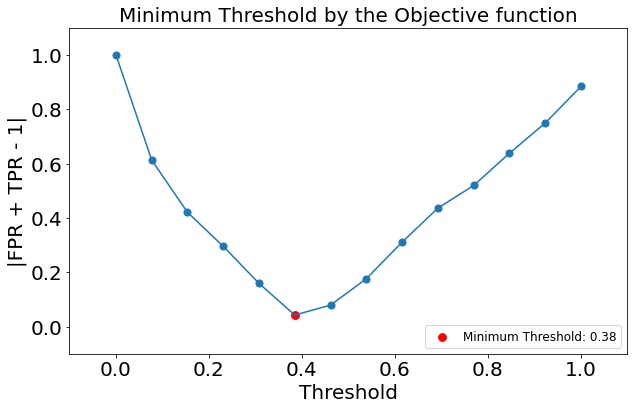

In [46]:
plt.figure(figsize=(10,6))
plt.scatter(th[1:],np.abs(fpr+tpr-1)[1:], s=50)
plt.plot(th[1:],np.abs(fpr+tpr-1)[1:])
itemindex = np.where(th==th[np.argmin(np.abs(fpr+tpr-1))])
plt.xlabel("Threshold", fontsize=20)
plt.ylabel("|FPR + TPR - 1|", fontsize=20)
plt.scatter(th[np.argmin(np.abs(fpr+tpr-1))],np.abs(fpr+tpr-1)[itemindex], c='r', s=60, label='Minimum Threshold: {:.2f}'.format(th[np.argmin(np.abs(fpr+tpr-1))]))
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower right',fontsize=12)
plt.title('Minimum Threshold by the Objective function', fontsize=20)
plt.show()

minimo_threshold = th[np.argmin(np.abs(fpr+tpr-1))]

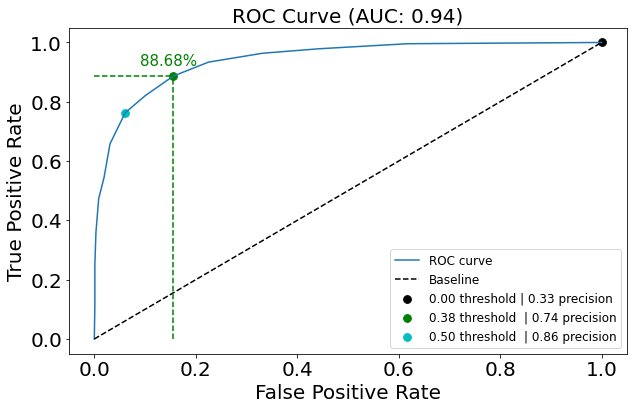

In [47]:
th_range_array = np.array([0, minimo_threshold, 0.501])
threshold_roc_plotter(knnX_test, knny_test, th_range_array, clf)

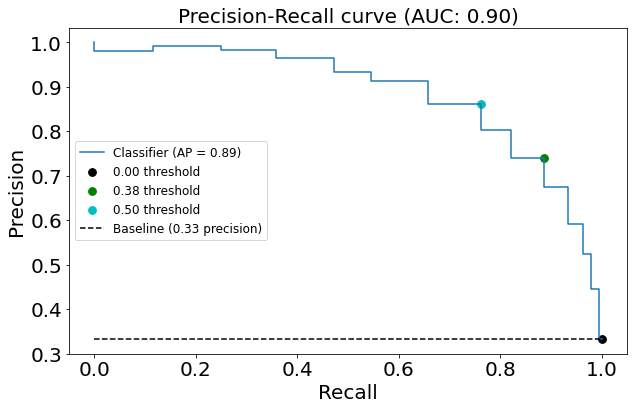

In [48]:
fig = plt.figure(figsize=(10,6))

ax = plt.axes()
display = PrecisionRecallDisplay.from_predictions(knny_test, knny_score[:,1], ax = ax)
display.ax_.set_title("Precision-Recall curve (AUC: {:.2f})".format(proc_auc), fontsize=20)

plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

colori = {0:'k', 1:'g', 2:'c', 3:'r', 4:'m', 5:'y', 6:'b'}

for i, thr in enumerate(th_range_array):
    if thr==1:
        knny_pred_test = [1 if v > thr else 0 for v in clf.predict_proba(knnX_test)[:,1]]
    else:
        knny_pred_test = [1 if v >= thr else 0 for v in clf.predict_proba(knnX_test)[:,1]]
        
    cf = confusion_matrix(knny_test, knny_pred_test, labels=[1,0])
    TP = cf[0][0]
    FN = cf[0][1]
    FP = cf[1][0]
    TN = cf[1][1]

    veri = TP / (TP + FN)
    falsi = FP / (FP + TN)
        
    if thr != 1:
        precisione = TP / (TP + FP)
        plt.scatter(veri, precisione, c=str(colori[i]), s=60, label='{:.2f} threshold'.format(thr))
        
    if thr == 0:
        nervi = precisione

plt.plot([0,1], [nervi,nervi], '--k', label='Baseline ({:0.2f} precision)'.format(nervi))
plt.legend(fontsize=12)